## Linear regression

For more information see chapter 3

In [1]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

##### The function our model will try to regress will be the following:

$$ y(x) = 2*x + 3$$

In [2]:
x = np.random.uniform(low=-10, high=10, size=1000)
noise = np.random.normal(loc=1.5, scale=3, size=1000)
y = 2 * x + 3 + noise
x = x.reshape(-1, 1)
y = y.reshape(-1, 1)

data = np.hstack([x, y])
df = pd.DataFrame(data, columns=["x", "y"])

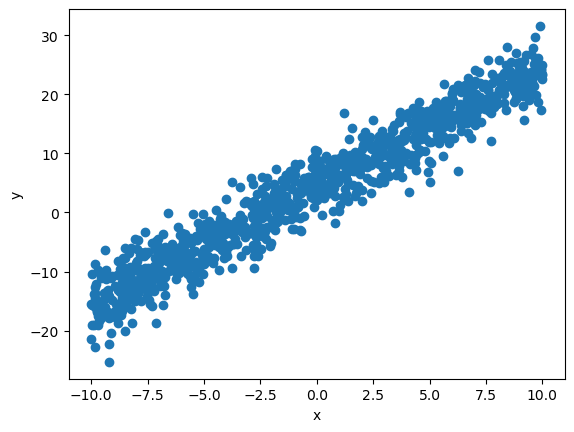

In [3]:
plt.scatter(df["x"], df["y"])
plt.ylabel('y')
plt.xlabel('x');

#### 1. DataLoader

In [4]:
class CustomDataLoader:
    def __init__(self, data, target, val_size=0.3, test_size=0.2, batch_size=64):  
        self.batch_size = batch_size
        self.X_train, self.X_val, self.y_train, self.y_val = train_test_split(data.values, target.values, test_size=val_size, random_state=42)
        self.X_val, self.X_test, self.y_val, self.y_test = train_test_split(self.X_val, self.y_val, test_size=test_size, random_state=42)

        # If scaling is needed here the data is scaled


    def get_data_loaders(self):
        train_dataset = TensorDataset(torch.tensor(self.X_train, dtype=torch.float32),
            torch.tensor(self.y_train, dtype=torch.float32))
        val_dataset = TensorDataset(torch.tensor(self.X_val, dtype=torch.float32),
            torch.tensor(self.y_val, dtype=torch.float32))
        test_dataset = TensorDataset(torch.tensor(self.X_test, dtype=torch.float32),
            torch.tensor(self.y_test, dtype=torch.float32))
        
        
        train_loader = DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=self.batch_size, shuffle=True)
        test_loader = DataLoader(test_dataset, batch_size=self.batch_size, shuffle=False)

        return train_loader, val_loader, test_loader



X = df[["x"]]
y = df["y"]
custom_loader = CustomDataLoader(X, y)
train_loader, val_loader, test_loader = custom_loader.get_data_loaders()

#### 2. Model

In [5]:
class Model(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.linear = nn.Linear(in_features, out_features) # If input size is unknown use LazyLinear
        
    def forward(self, x):
        y_pred = self.linear(x)
        return y_pred

In [6]:
model = Model(in_features=X.shape[1], out_features=1)
print(model)

for name, param in model.named_parameters():
    print(name, '\t', param.item())

Model(
  (linear): Linear(in_features=1, out_features=1, bias=True)
)
linear.weight 	 -0.01556241512298584
linear.bias 	 -0.5746667385101318


In [7]:
# Untrained model
x = torch.tensor([2.0])
print(model.forward(x))   # equivalent to print(model(x))

tensor([-0.6058], grad_fn=<AddBackward0>)


Initial weight: -0.01556242, Initial bias: -0.57466674


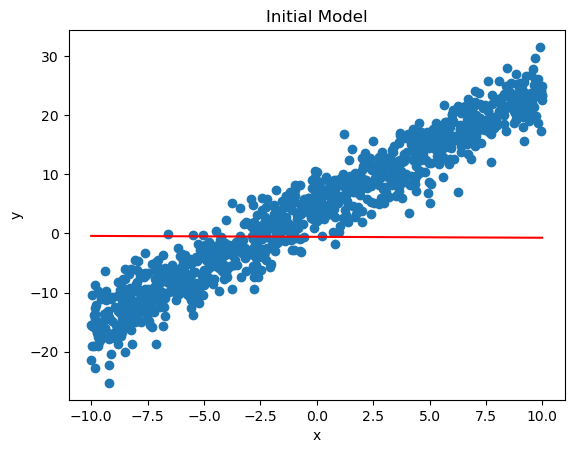

In [8]:
# Plotting the intial model

x1 = np.array([X.min(),X.max()])

w1,b1 = model.linear.weight.item(), model.linear.bias.item()
print(f'Initial weight: {w1:.8f}, Initial bias: {b1:.8f}')
y1 = x1*w1 + b1

plt.scatter(X, y)
plt.plot(x1,y1,'r')
plt.title('Initial Model')
plt.ylabel('y')
plt.xlabel('x');

#### 3. The Loss function
We could write our own function to apply a Mean Squared Error (MSE) that follows

$$MSE = \frac {1} {n} \sum_{i=1}^n {(y_i - \hat y_i)}^2 = \frac {1} {n} \sum_{i=1}^n {(y_i - (wx_i + b))}^2\$$

In [9]:
criterion = nn.MSELoss()

#### 4. Optimizer

Here we'll use <a href='https://en.wikipedia.org/wiki/Stochastic_gradient_descent'>Stochastic Gradient Descent</a> (SGD) with an applied <a href='https://en.wikipedia.org/wiki/Learning_rate'>learning rate</a> (lr) of 0.001. Recall that the learning rate tells the optimizer how much to adjust each parameter on the next round of calculations. Too large a step and we run the risk of overshooting the minimum, causing the algorithm to diverge. Too small and it will take a long time to converge.

For more complicated (multivariate) data, you might also consider passing optional <a href='https://en.wikipedia.org/wiki/Stochastic_gradient_descent#Momentum'><tt>momentum</tt></a> and <a href='https://en.wikipedia.org/wiki/Tikhonov_regularization'><tt>weight_decay</tt></a> arguments. Momentum allows the algorithm to "roll over" small bumps to avoid local minima that can cause convergence too soon. Weight decay (also called an L2 penalty) applies to biases.

For more information, see <a href='https://pytorch.org/docs/stable/optim.html'><strong><tt>torch.optim</tt></strong></a>

In [10]:
optimizer = torch.optim.SGD(model.parameters(), lr = 0.001)

#### 5. Train the model

Epoch 1/2000, Train Loss: 105.2849, Test Loss: 64.0229
Epoch 101/2000, Train Loss: 9.3813, Test Loss: 8.8290
Epoch 201/2000, Train Loss: 9.0910, Test Loss: 8.3971
Epoch 301/2000, Train Loss: 9.0922, Test Loss: 8.3830
Epoch 401/2000, Train Loss: 9.0900, Test Loss: 8.3748
Epoch 501/2000, Train Loss: 9.0932, Test Loss: 8.3780
Epoch 601/2000, Train Loss: 9.0962, Test Loss: 8.3815
Epoch 701/2000, Train Loss: 9.0970, Test Loss: 8.3822
Epoch 801/2000, Train Loss: 9.0936, Test Loss: 8.3828
Epoch 901/2000, Train Loss: 9.0967, Test Loss: 8.3792
Epoch 1001/2000, Train Loss: 9.0951, Test Loss: 8.3768
Epoch 1101/2000, Train Loss: 9.0917, Test Loss: 8.3772
Epoch 1201/2000, Train Loss: 9.0899, Test Loss: 8.3799
Epoch 1301/2000, Train Loss: 9.0910, Test Loss: 8.3752
Epoch 1401/2000, Train Loss: 9.0885, Test Loss: 8.3786
Epoch 1501/2000, Train Loss: 9.0894, Test Loss: 8.3792
Epoch 1601/2000, Train Loss: 9.0923, Test Loss: 8.3786
Epoch 1701/2000, Train Loss: 9.1016, Test Loss: 8.3790
Epoch 1801/2000, Tr

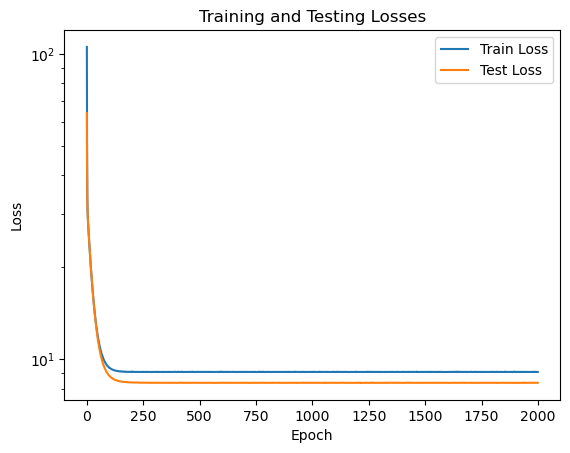

0.9182356309970078

In [11]:
class Trainer:
    def __init__(self, model, optimizer, criterion, train_loader, val_loader):
        self.model = model
        self.optimizer = optimizer
        self.criterion = criterion
        self.train_loader = train_loader
        self.val_loader = val_loader
    
    def train(self, max_epochs):
        self.train_losses = []
        self.val_losses = []

        # Training
        for epoch in range(max_epochs):
            self.model.train
            train_loss = 0

            for inputs, labels in self.train_loader:
                self.optimizer.zero_grad()
                outputs = self.model(inputs)
                loss = self.criterion(outputs.squeeze(), labels)  # Assuming output shape is [batch_size, 1]
                loss.backward()
                self.optimizer.step()
                train_loss += loss.item() * inputs.size(0)
            train_loss /= len(self.train_loader.dataset)
            self.train_losses.append(train_loss)

            # Validation
            self.model.eval()
            val_loss = 0.0
            with torch.no_grad():
                for inputs, labels in self.val_loader:
                    outputs = self.model(inputs)
                    loss = self.criterion(outputs.squeeze(), labels)
                    val_loss += loss.item() * inputs.size(0)
                val_loss /= len(self.val_loader.dataset)
            self.val_losses.append(val_loss)

            if epoch % 100 == 0:
                print(f'Epoch {epoch+1}/{max_epochs}, Train Loss: {train_loss:.4f}, Test Loss: {val_loss:.4f}')
 
        return self.model
    
    def plot_losses(self, train_losses, test_losses):
        plt.plot(train_losses, label='Train Loss')
        plt.plot(test_losses, label='Test Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.yscale('log')  # Set y-axis scale to logarithmic
        plt.title('Training and Testing Losses')
        plt.legend()
        plt.show()
    
    def evaluation(self, model, test_loader):
        model.eval()
        with torch.no_grad():
            test_preds = []
            test_targets = []
            for inputs, labels in test_loader:
                outputs = model(inputs)
                test_preds.extend(outputs.squeeze().tolist())
                test_targets.extend(labels.tolist())
        test_r2 = r2_score(test_targets, test_preds)

        return test_r2
            

trainer = Trainer(model, optimizer, criterion, train_loader, val_loader)   
model = trainer.train(2000)      
trainer.plot_losses(trainer.train_losses, trainer.val_losses)
trainer.evaluation(model, test_loader)

In [12]:
w1,b1 = model.linear.weight.item(), model.linear.bias.item()
print(f'Current weight: {w1:.8f}, Current bias: {b1:.8f}')
y1 = x1*w1 + b1

Current weight: 1.99720573, Current bias: 4.33261728


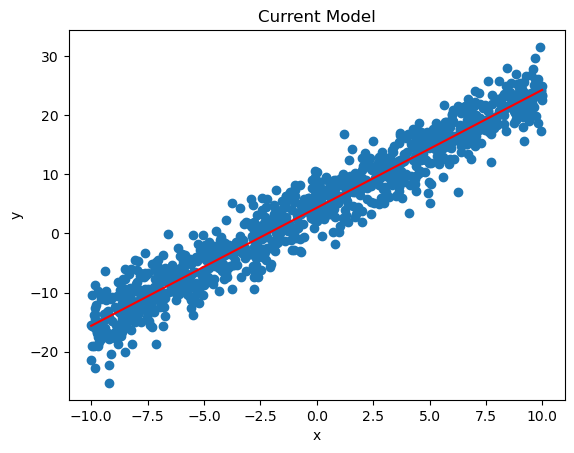

In [13]:
plt.scatter(X, y)
plt.plot(x1,y1,'r')
plt.title('Current Model')
plt.ylabel('y')
plt.xlabel('x');